**Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.**

In [170]:
from google.colab import files
uploaded = files.upload()

Saving StudentsPerformance.csv to StudentsPerformance.csv


In [196]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit, GridSearchCV, train_test_split,cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from warnings import simplefilter

simplefilter('ignore')

In [174]:
df = pd.read_csv('./StudentsPerformance.csv', sep=',')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [175]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
df["gender"] = le.fit_transform(df[['gender']])
df["race/ethnicity"] = le.fit_transform(df[['race/ethnicity']])
df["parental level of education"] = le.fit_transform(df[['parental level of education']])
df["lunch"] = le.fit_transform(df[['lunch']])
df["test preparation course"] = le.fit_transform(df[['test preparation course']])
df.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
5,0,1,0,1,1,71,83,78
6,0,1,4,1,0,88,95,92
7,1,1,4,0,1,40,43,39
8,1,3,2,0,0,64,64,67
9,0,1,2,0,1,38,60,50


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   gender                       1000 non-null   int64
 1   race/ethnicity               1000 non-null   int64
 2   parental level of education  1000 non-null   int64
 3   lunch                        1000 non-null   int64
 4   test preparation course      1000 non-null   int64
 5   math score                   1000 non-null   int64
 6   reading score                1000 non-null   int64
 7   writing score                1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


In [177]:
df.dropna()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
...,...,...,...,...,...,...,...,...
995,0,4,3,1,0,88,99,95
996,1,2,2,0,1,62,55,55
997,0,2,2,0,0,59,71,65
998,0,3,4,1,0,68,78,77


Видим, в датасете нет пропусков и нет категориальных признаков. Отделим целевой признак.

In [178]:
y = df['writing score']
X = df.drop('writing score', axis=1)

Разделим выборку на обучающую и тестовую

In [179]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Обучение методом k ближайших соседей с произвольным k


In [180]:
def print_metrics(y_test, y_pred):
    print(f"R^2_score: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    


Возьмем k=5

In [181]:
regr_5 = KNeighborsRegressor(n_neighbors=5)
regr_5.fit(x_train, y_train)

KNeighborsRegressor()

In [182]:
print_metrics(y_test, regr_5.predict(x_test))

R^2_score: 0.8972447325769854
MSE: 24.092
MAE: 3.958


Кросс-валидация


Стратегия K-fold

In [183]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.92246926 0.90579614 0.86909023 0.89364136 0.86464956 0.91996437
 0.87964346 0.91824669 0.89737818 0.91410384]
0.8984983068096172 ± 0.020280804234952616


Стратегия Repeated K-fold

In [184]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.89771308 0.90791147 0.92456346 0.88171317 0.86918563 0.91452592
 0.89398763 0.89344157 0.8917589  0.8971498 ]
0.8971950635085225 ± 0.014975462914240333


Стратегия ShuffleSplit

In [185]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.94049204 0.92247096 0.90544201 0.90097684 0.90747489 0.90449472
 0.89743657 0.90396739 0.84988098 0.91612838]
0.9048764766868945 ± 0.021926575439064042


Подбор гиперпараметра **K**

In [190]:
n_range = np.array(range(1, 30, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [191]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.cv_results_

{'mean_fit_time': array([0.00568979, 0.00719857, 0.00421   , 0.00736759, 0.00467978,
        0.00682645, 0.00656686, 0.00615673, 0.00778916, 0.00745628,
        0.00575051, 0.00535414, 0.00579717, 0.00537159, 0.01390336]),
 'mean_score_time': array([0.00791268, 0.0083848 , 0.00538678, 0.00598438, 0.003637  ,
        0.00666304, 0.00583115, 0.00703018, 0.00912354, 0.0071372 ,
        0.00909035, 0.00551796, 0.00724914, 0.00612736, 0.01922967]),
 'mean_test_score': array([0.84536639, 0.88790545, 0.89268748, 0.8949408 , 0.89733302,
        0.89842712, 0.89866011, 0.89959865, 0.89978372, 0.89984801,
        0.89992064, 0.89998075, 0.89978298, 0.89976387, 0.89974432]),
 'mean_train_score': array([0.99936177, 0.94777958, 0.93450975, 0.92714124, 0.92273012,
        0.92025788, 0.91839347, 0.91620058, 0.91454801, 0.91412177,
        0.91344056, 0.91227984, 0.91132896, 0.91013849, 0.90920084]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29],
    

In [192]:
gs.best_params_

{'n_neighbors': 23}

In [193]:
gs.best_score_

0.8999807515354202

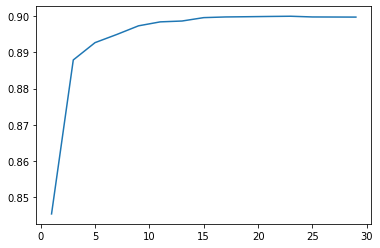

In [194]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

На графике видно, что наилучшее значение достигается в районе 20 соседей


In [195]:
regr_best = KNeighborsRegressor(**gs.best_params_)
regr_best.fit(x_train, y_train)
print_metrics(y_test, regr_best.predict(x_test))

R^2_score: 0.9011104146809135
MSE: 23.18565217391304
MAE: 3.809565217391304
